# DENMARK INTERNATIONAL TRADE

## 1. Import packages

In [1]:
import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import pandas_datareader 
import pydst 

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## 2. Read and clean data

### 2.1 Total external trade in goods and services data

We read the goods trade data in the excel file ``tradequartelydata.xlsx``. Afterwards, we clean the file by removing and renaming columns and rows and changing the cell values of certain columns.

In [2]:
#a. Loading and removing the first two rows when reading
imp = pd.read_excel('tradequartelydata.xlsx', skiprows = 2) 

#b. Dropping columns
drops = ['Unnamed: 0', 'Unnamed: 1'] 
imp.drop(drops, axis=1, inplace=True) #axis = 1: columns, inplace=True: changed, no copy made

#c. Renaming columns and cells
imp.rename(columns = {'Unnamed: 2':'Flow'}, inplace=True) #renaming the column 'Unnamed: 2' to 'Flow'
imp.loc[imp.Flow == 'Imports', 'Flow'] = 'Goods total imports' #renaming the cell import under column 'Flow' with 'Goods total imports'
imp.loc[imp.Flow == 'Exports', 'Flow'] = 'Goods total exports' #renaming the cell import under column 'Flow' with 'Goods total exports'

We read the service trade data in the excel file ``servicegoodstot.xlsx``. As before we clean the file by removing and renaming columns and rows and changing the cell values of certain columns:

In [3]:
#a. Loading the data and removing the first two rows 
imps = pd.read_excel('servicegoodstot.xlsx', skiprows = 2)

#b. Dropping columns
drops = ['Unnamed: 0', 'Unnamed: 1']
imps.drop(drops, axis=1, inplace=True) 

#c. Renaming columns and cell
imps.rename(columns = {'Unnamed: 2':'Flow'}, inplace=True)
imps.loc[imps.Flow == 'Imports', 'Flow'] = 'Services total imports'
imps.loc[imps.Flow == 'Exports', 'Flow'] = 'Services total exports'

We can now create a dataframe with both the data for goods and services with the final purpose to plot their trends in the same graph. Subsequently, we transpose the obtained dataframe and we set the quarters as the new index. We trasform the quarters from object into date type through the general function *pd.to_datetime* and we delete the index name so that it will not appear in the legend of the plot.

In [4]:
#d. Merging the two dataset through the concat method
int_tr = pd.concat([imp,imps], axis=0, ignore_index=True)  

#e. Transposing the new dataframe and setting column 'Flow' as index
int_tr1 = int_tr.set_index('Flow').T

#f. Changing index data type from object to datetime and removing his name
int_tr1.index = pd.to_datetime(int_tr1.index)
del int_tr1.index.name

In [ ]:
#### 2.2.1 Balance of trade

We want to calculate the overall Balance of Trade. For doing so we need firstly to calculate the total amount of exports and imports and subsequently their difference.

In [22]:
#a. Summing imports and exports
int_tr2 = int_tr1.copy()
int_tr2['total_exports'] = int_tr2['Goods total exports']+int_tr2['Services total exports']
int_tr2['total_imports'] = int_tr2['Goods total imports']+int_tr2['Services total imports']

#b. Calculating the difference
int_tr2['balance_of_trade'] = int_tr2['total_exports']-int_tr2['total_imports']

### 2.2 Data of trade partners in goods imports and exports

#### 2.2.1 Exports data

We upload the excel file ``tradescountries.xlsx``, removing unnecessary rows. We clean the file by removing and renaming columns and rows and changing the cell values of certain columns for simplicity reasons.

In [5]:
#a. Loading the data and removing the first two rows
tr_par = pd.read_excel('tradecountries.xlsx', skiprows = [0,1,3,14])

#b. Dropping columns
to_drop = ['Unnamed: 0']
tr_par.drop(to_drop, axis=1, inplace=True) # axis = 1 -> columns, inplace=True -> changed, no copy made

#c. Renaming columns and cells values
tr_par.rename(columns = {'Unnamed: 1':'impexp','Unnamed: 2':'Country'}, inplace=True)
d = {'Imports (excl. vessels and aircraft, fuels etc.)':'Imports','Exports (excl. vessels and aircraft, fuels etc.)':'Exports'}
tr_par1 = tr_par.replace(d)

In this first moment, as we only want the exports data, we select in the column *impexp* the rows with value **Export**. We make a copy of the resulting dataframe and remove the column *impexp* as it is not useful anymore.

In [6]:
#d. Selecting rows with 'Exports' value
tr_par2 = tr_par1.loc[tr_par1['impexp'] == 'Exports']

#e. Making a copy and removing column 'impexp'
tr_par3 = tr_par2.copy()
to_drp = ['impexp']
tr_par3.drop(to_drp, axis=1, inplace=True)

Before transposing the dataframe to plot the data, we want to get rid of the default *[0,...,n] index*. Afterwards, as our analysis is concentrating during the period 2005-2019, we select data collected after January 2005 and we remove the last observation of January 2020 .

In [7]:
#f. Changing index and removing name
tr_par3.set_index('Country',inplace=True)
tr_par3.index.name = None

#g. Transposing the dataframe and changing index name
tr_par4 = tr_par3.transpose()
tr_par4.index.name = 'Date'

#h. Selecting data
tr = tr_par4.iloc[96:]
tr.reset_index(inplace=True)
tr1 = tr.drop(tr.index[180])

As we want to realize a stacked bar graph to detect the volume exchange with every the various countries we need to add two new columns *Other EU countries* and *Other non-EU countries* and to delete the previous columns *EU* and *World outside EU* which contain the values already shown in other columns. Finally, we convert *Date* column from object to date type.

In [8]:
#i. Creating new columns as result of algebraic calculations 
tr2 = tr1.copy()
tr2['Other EU countries'] = tr2['EU'] - tr2.iloc[:,2:7].sum(axis=1)
tr2['Other non-EU countries'] = tr2['World outside EU'] - tr2.iloc[:,8:11].sum(axis=1)

#j. Removing unnecessary columns
drop = ['EU','World outside EU']
tr3 = tr2.drop(drop, axis=1, inplace=False)

#k. Converting into date type and setting 'Date' column as index
tr3['Date'] =  pd.to_datetime(tr3['Date'], format='%YM%m')
tr3 = tr3.set_index('Date')

Our final goal is to construct a stacked bar chart that show the relative importance of every trade partner for every year. So, firstly, we merge our monthly observations into annual observations and we construct a function that does the job (this function will be used later as well). Afterwards we calculate relative percentages with respect to the sum of values for each row.

In [9]:
#l. Function to merge monthly observations into annual observations
def convert_to_annual(df):
    """Aggregate 12 months of data into an annual value"""
    oth_col = df.columns
    i_col = [x for x in df.columns if x not in oth_col]
    df_up = df.resample('Y', kind = 'period')[oth_col].sum()
    df_up.index = df_up.index
    df_up[i_col] = df[i_col]  
    return df_up

tr3 = convert_to_annual(tr3)

#m. Calculating relative percentages 
tr3_perc = tr3.divide(tr3.sum(axis=1), axis=0)

#### 2.2.2 Imports data

We basically perform exactly the same steps as we did for the export data case. The excel file is the same as before but as we want now the imports data, we select in the column *impexp* the rows with value **Imports**.

In [10]:
#d. Selecting rows with 'Imports' value
tr_imp = tr_par1.loc[tr_par1['impexp'] == 'Imports']

#e. Making a copy and removing column 'impexp'
tr_imp1 = tr_imp.copy()
to_drp = ['impexp']
tr_imp1.drop(to_drp, axis=1, inplace=True)

#f. Changing index and removing name
tr_imp1.set_index('Country',inplace=True)
tr_imp1.index.name = None

#g. Transposing the dataframe and changing index name
tr_imp2 = tr_imp1.transpose()
tr_imp2.index.name = 'Date'

#h. Selecting data
trimp = tr_imp2.iloc[96:]
trimp.reset_index(inplace=True)
trimp1 = trimp.drop(tr.index[180])

#i. Creating new columns as result of algebraic calculations 
trimp2 = trimp1.copy()
trimp2['Other EU countries'] = trimp2['EU'] - trimp2.iloc[:,2:7].sum(axis=1)
trimp2['Other non-EU countries'] = trimp2['World outside EU'] - trimp2.iloc[:,8:11].sum(axis=1)

#j. Removing unnecessary columns
drop = ['EU','World outside EU']
trimp3 = trimp2.drop(drop, axis=1, inplace=False)

#k. Converting into date type and setting 'Date' column as index
trimp3['Date'] =  pd.to_datetime(trimp3['Date'], format='%YM%m')
trimp3 = trimp3.set_index('Date')

#l. Merge monthly observations into annual observations
trimp3 = convert_to_annual(trimp3)

#m. Calculating relative percentages 
trimp3_perc = trimp3.divide(trimp3.sum(axis=1), axis=0)

### 3. Data on exports and imports by type of goods

#### 3.1 Exports by type of goods data

We download the data directly from Statistics Denmark through the API. The subject we are interested in is the number *'13: External Economy* and the precise table is *UHV1*.

In [11]:
#a. Loading data through an API in English
Dst = pydst.Dst(lang='en') 
Dst.get_subjects()

#b. Selecting subject and table
tables = Dst.get_tables(subjects=['13'])
tables[tables.id == 'UHV1']
ind_vars = Dst.get_variables(table_id='UHV1')

We extract the data that we want to work with. We select *INDUD: 2* and *SÆSON: SÆSON* because we want seasonally adjusted exports data and we download for now all the information regarding the type of goods *(ART)* and monthly observation *(Tid)*. Subsequently, we start cleaning and preparing the dataframe for analysis. We drop and rename colums and we trasform monthly dates from subject into datetime type.

In [12]:
#c. Selecting data
var = {'INDUD':['2'],'SÆSON':['SÆSON'],'ART':['*'],'Tid':['*']}
gdr= Dst.get_data(table_id = 'UHV1', variables=var)

#d. Renaming and deleting columns and rows
gdr.rename(columns = {'INDUD':'ImpExp','ART':'Type of good','TID':'Date','INDHOLD':'Values'}, inplace=True)
to_drop = ['ImpExp','SÆSON']
gdr.drop(to_drop, inplace=True, axis=1)
gdr.drop(gdr.index[2])

#e. Changing type
gdr['Date'] =  pd.to_datetime(gdr['Date'], format='%YM%m')

We now structure the dataframe to have the monthly dates as our index rows and the distinct goods as our columns through the *pivot* method. Afterwords we remove columns that will not be useful for our analysis. As we are interested in the period 2005-2019, we select only the data referring to this period of time.

In [13]:
#f. Structuring dataframe 
gdr1 = gdr.pivot(index='Date', columns='Type of good', values='Values')

#g. Removing columns
todrop = ['TOTAL','TOTAL (excl. vessels, aircraft, fuels etc.)']
gdr1.drop(todrop, axis=1, inplace = True) 

#h. Selecting data
gdr2 = gdr1.iloc[96:]
gdr2 = gdr2.drop(gdr2.index[180])

Our final goal is to construct, in the analysis part, an interactive pie chart that shows the relative importance of every category of good with respect to the overall export of goods for each year. So, firstly, we merge our monthly observations into annual observations and we construct a function that does the job. Afterwards we calculate relative percentages with respect to the sum of values for each row.

In [14]:
#i. Function to merge monthly observations into annual observations
def convert_to_annual(df):
    """Aggregate 12 months of data into an annual value"""
    oth_col = df.columns
    i_col = [x for x in df.columns if x not in oth_col]
    df_up = df.resample('Y', kind = 'period')[oth_col].sum()
    df_up.index = df_up.index
    df_up[i_col] = df[i_col]  
    return df_up

gdr2 = convert_to_annual(gdr2)

#j. Calculating relative percentages 
gdr2_perc = gdr2.divide(gdr2.sum(axis=1), axis=0)

#### 3.2 Imports by type of goods data

We basically perform exactly the same steps as we did for the *export by type of data case*. As we did previosly, we download the data directly from Statistics Denmark through the API. The *subject* we are interested in is still the number *'13: External Economy* and the particular *table* is as before *UHV1*. The only difference is that we now select *INDUD: 1* as we want data regarding the imports and not the exports.

In [15]:
#c. Selecting data
var1 = {'INDUD':['1'],'SÆSON':['SÆSON'],'ART':['*'],'Tid':['*']}
fdr= Dst.get_data(table_id = 'UHV1', variables=var1)

#d. Renaming and deleting columns and rows
fdr.rename(columns = {'INDUD':'ImpExp','ART':'Type of good','TID':'Date','INDHOLD':'Values'}, inplace=True)
to_drop = ['ImpExp','SÆSON']
fdr.drop(to_drop, inplace=True, axis=1)
fdr.drop(gdr.index[2])

#e. Changing type
fdr['Date'] =  pd.to_datetime(fdr['Date'], format='%YM%m')

#f. Structuring dataframe 
fdr1 = fdr.pivot(index='Date', columns='Type of good', values='Values')

#g. Removing columns
todrop = ['TOTAL','TOTAL (excl. vessels, aircraft, fuels etc.)']
fdr1.drop(todrop, axis=1, inplace = True) 

#h. Selecting data
fdr2 = fdr1.iloc[96:]
fdr2 = fdr2.drop(fdr2.index[180])

#i. Merge monthly observations into annual observations
fdr2 = convert_to_annual(fdr2)

#j. Calculating relative percentages 
fdr2_perc = fdr2.divide(fdr2.sum(axis=1), axis=0)

## 3. Analysis

We start our analysis by plotting the trend of goods and services trade.

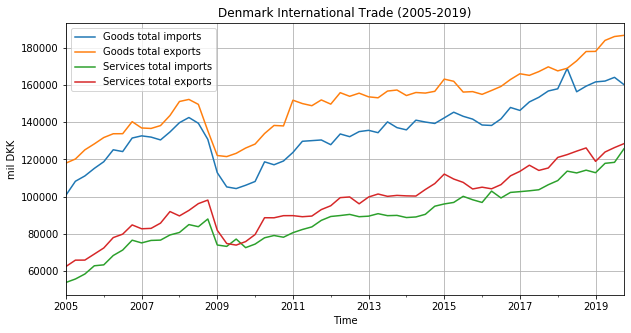

In [16]:
fig1 = int_tr1.plot(figsize=(10,5))
plt.title('Denmark International Trade (2005-2019)')
plt.xlabel('Time')
plt.ylabel('mil DKK')
plt.legend(['Goods total imports', 'Goods total exports', 'Services total imports', 'Services total exports'], loc=2)
plt.grid(True)
plt.show()

From the figure above, we can easily notice that Denmark has a bigger exchange of goods with respect to services. During the last 15 years for both goods and services the trend has been positive. The only oddity is represented by the year 2009 where both imports and exports have suffered a drastic collapse evidently due to the great global recession. From the graph we can also deduct that net balance for Denmark has been positive during the last 15 years with an overall better result for the commercial goods trade. We are going to plot it as well:

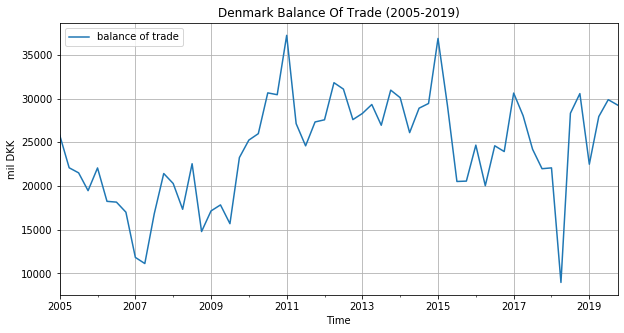

In [27]:
fig2 = int_tr2.plot( y = 'balance_of_trade', figsize=(10,5))
plt.title('Denmark Balance Of Trade (2005-2019)')
plt.xlabel('Time')
plt.ylabel('mil DKK')
plt.legend(['Balance of trade'], loc=2)
plt.grid(True)
plt.show()

The line illustrates the balance trade of Denmark over the 15 years period 2005-2019. The BOT amount has fluctuated during this period. In any case, Denmark seems to have never experience a significant deficit during this time. It reaches a peak in 2011 and 2015 of around 37000 mil Kr and the lowest amounts in 2007 and 2018. 

We now plot the horizontal stacked bar chart which show the relative importance of every trade partner with respect to the export of goods

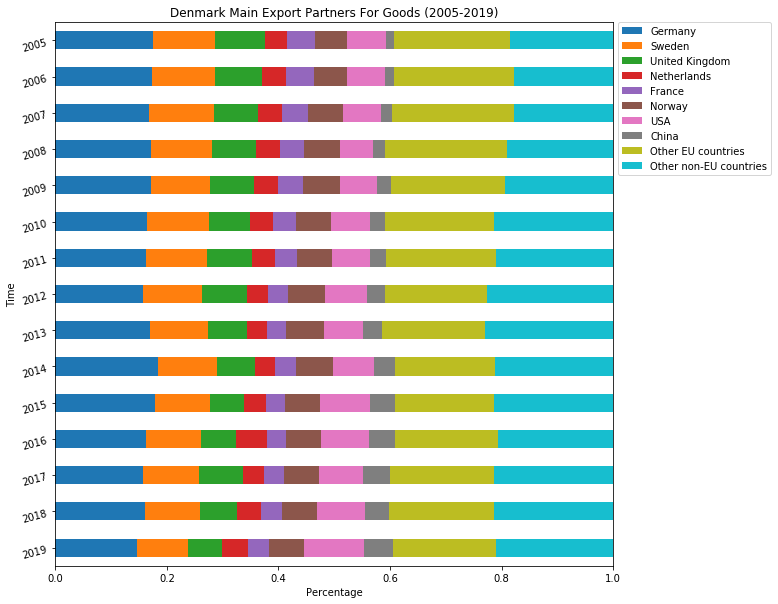

In [17]:
fig3 = tr3_perc.plot(figsize=(10,10), kind='barh', stacked=True, rot=15, )
plt.gca().invert_yaxis()
fig3.set_title('Denmark Main Export Partners For Goods (2005-2019)')
fig3.set_xlabel('Percentage')
fig3.set_ylabel('Time')
fig3.set_xlim(0,1)
fig3.legend(loc= 'upper left', bbox_to_anchor=(1,1.01), prop={'size': 10})
txt = "Descr: Data seasonally adjusted" 
fig3.grid(False)
plt.show(fig3)

Germany, Sweden and United Kingdom seem to be the most important european destinations for danish goods even if UK has slightly decreased from 2005 to 2019. We can notice that their relative importance has changed a little during the last 15 years representing around 30% of overall exports value.   
Moreover, United States and China have grown their relative importance and they now count for more that 10% of the total exports of goods. Netherlands and France seems to play and mantain a marginal role while Norway remains a relevant trade partner if we take into consideration countries outside the European Union.  
Finally, it is important to underline that the remaining countries collected under the categories *Other EU countries* and *Other non-EU countries* are still the destination of around 40% of the danish goods exports. 

We now plot the horizontal stacked bar chart which show the relative importance of every trade partner with respect to the imports of goods

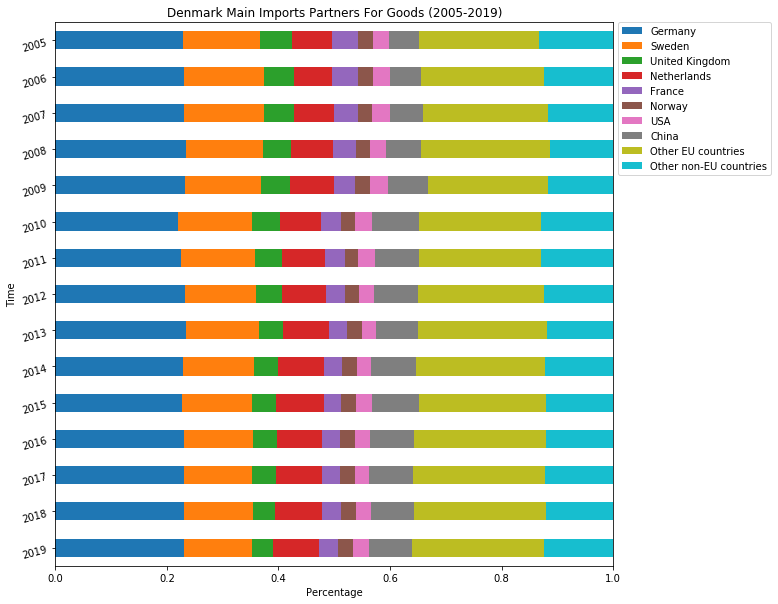

In [18]:
fig4 = trimp3_perc.plot(figsize=(10,10), kind='barh', stacked=True, rot=15, )
plt.gca().invert_yaxis()
fig4.set_title('Denmark Main Imports Partners For Goods (2005-2019)')
fig4.set_xlabel('Percentage')
fig4.set_ylabel('Time')
fig4.set_xlim(0,1)
fig4.legend(loc= 'upper left', bbox_to_anchor=(1,1.01), prop={'size': 10})
txt = "Descr: Data seasonally adjusted" 
fig4.grid(False)
plt.show(fig3)

Germany and Sweden are also confirmed to be important trading partners for Denmark regarding the goods imports.   
Their relative importance has changed a little during the last 15 years representing around 35% of overall imports value.   
Great Britain, United States and Norway that represent outstanding export destinations are less relevant for the supply of goods. China and Netherlands, instead, seem to play a major role for imports in comparison to exports with the latter counting around 10% of the danish overall goods imports. France mantains a marginal role also with respect to imports.  
The remaining countries collected under the categories *Other EU countries* and *Other non-EU countries* represent around 40% of the total imports value.   
Finally, we can notice that no major change has occured during the last 15 years and the composition of the market has remained basically the same. 

We now costruct the interactive pie chart to show the changes in composition of exports by type of goods during time.

In [19]:
gdr2_perc.index = gdr2_perc.index.to_series().astype(str)
gdr2_perc.index = gdr2_perc.index.to_series().astype(int)
gdr3_perc = gdr2_perc.copy()
gdr3_perc = gdr3_perc.reset_index()

def _plot_timeseries(df, years):
    fig = plt.figure(dpi=200) #Creating figure
    ax = fig.add_subplot(1,1,1)
    
    toplot= df[df['Date']==years][df.columns.difference(['Date'])]
    labels = df.columns[1:]
    explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
    ax.pie(toplot, autopct='%1.1f%%', textprops={'fontsize': 7}, labels = labels, explode = explode, shadow=True, startangle=140)
    
    ax.axis('equal')
def plot_time(df):
    widgets.interact(_plot_timeseries, 
    df = widgets.fixed(df),
    years = widgets.IntSlider(
        description='Year',
        min=2005,
        max=2019,
        value=2005,
        orientation='horizontal',
        continuous_update=False,
    )                 
);  
    
fig5 = plot_time(gdr3_perc)
fig5

interactive(children=(IntSlider(value=2005, continuous_update=False, description='Year', max=2019, min=2005), …

Fist of all, we notice that the three main categories of goods exported in ***2005*** were, in order, *Machinery (excl. Transport Equipment)* (21,8%), *Live Animals, Food, Beverages and Tobacco* (17,7%) and *Miscellaneous Manufactured Articles* (17,4%). In ***2012*** they were *Machinery* (21,1%), *Animals, Food, Beverages and Tobacco* (18,1%) and *Chemicals* (17,1%) and in ***2019*** *Chemicals* (23.9%), *Machinery* (23.1%) and *Animals, Food, Beverages and Tobacco* (17.6%). This underlines the increasing importance that chemicals products have for the exports of the country and the relative stability of the *Machinery* and *food/Beverage* sectors during time.  
The type of good that decreases the most in relative terms during the last 15 years is *Minerals Fuels, Lubricants and related materials*. It passes from 11.5% in ***2005*** to 4.4% in ***2019*** suggesting an underlying declining trend.
*Trasport equipment*, *Vessels, aircrats, etc* and *Crude Materials, Inedibles, Except Fuels* have always represented a very small fraction of danish exports while *miscellaneous manufactured articles* and *material goods* are responsible for around 25% of the country exports.

We now plot, instead, the same interactive pie chart regarding the imports by type of goods.

In [20]:
fdr2_perc.index = fdr2_perc.index.to_series().astype(str)
fdr2_perc.index = fdr2_perc.index.to_series().astype(int)
fdr3_perc = fdr2_perc.copy()
fdr3_perc = fdr3_perc.reset_index()  
    
plot_time(fdr3_perc)

interactive(children=(IntSlider(value=2005, continuous_update=False, description='Year', max=2019, min=2005), …

The first important thing we notice is that *Machinery (excl. Transport Equipment)* remains the most imported type of goods regardless of the year that we consider. It is followed by the sectors *Miscellaneous manufactured articles*, *Material goods* and *Live Animals, Food, Beverages and Tobacco* which constitute around 45% of overall imports regardless of the year.   
*Mineral Fuels* and *Crude Materials* count on average for 10% of overall imports and *Vessels, Aircraft etc* always plays a marginal role .
An interesting fact is that *transport equipment* that it is not a relevant sector of export in Denmark counts for around 10% of overall imports

## 4. Conclusion